# Now after choosing the pairs wisely with statistical test, let's backtest the strategy

In [131]:
import json
import glob
import pandas as pd
import seaborn as sns 

sns.set_theme()

path = glob.glob('./*.json')[0]

with open(path) as fp:
    dict_pairs = json.load(fp)


In [132]:
dict_pairs['materials_and_mining'] =  [['LIN', 'RIO'], ['APD', 'RIO']]

In [133]:
dict_pairs

{'fast_food_chains': [],
 'retail_consumer_goods': [['WMT', 'PG'],
  ['DEO', 'EL'],
  ['BJ', 'PG'],
  ['COST', 'PG']],
 'industrial_and_aerospace_defense': [],
 'technology': [['SAP', 'AVGO'],
  ['MU', 'QCOM'],
  ['QCOM', 'MSFT'],
  ['TSM', 'GOOGL'],
  ['GOOGL', 'AVGO'],
  ['META', 'AVGO']],
 'energy': [['KMI', 'BP'],
  ['KMI', 'CVX'],
  ['KMI', 'DVN'],
  ['BP', 'ENB'],
  ['BP', 'TRP'],
  ['EPD', 'DVN'],
  ['HAL', 'ENB'],
  ['HAL', 'TRP'],
  ['SLB', 'ENB'],
  ['SLB', 'TRP'],
  ['XOM', 'EOG'],
  ['ENB', 'OXY'],
  ['WMB', 'DVN'],
  ['TRP', 'OXY']],
 'utilities': [['DUK', 'SO']],
 'communication_and_media': [],
 'financial_sector': [['MS', 'IBKR'],
  ['MA', 'SCHW'],
  ['WFC', 'SCHW'],
  ['BAC', 'SCHW'],
  ['V', 'SCHW'],
  ['JPM', 'SCHW']],
 'materials_and_mining': [['LIN', 'RIO'], ['APD', 'RIO']],
 'real_estate': [['O', 'VICI']],
 'pharma': [['ABBV', 'NVS']],
 'semiconductors': [],
 'airlines': [['LUV', 'JBLU']]}

In [134]:
dict_df = {key:[] for key in dict_pairs.keys()}

In [135]:
path_start = '../data_intraday/'

for key in dict_pairs.keys():
    
    list_pairs = dict_pairs[key]
    if len(list_pairs) != 0:
        for pairs in list_pairs:
                    
            stock_1 = pairs[0]
            stock_2 = pairs[1]

            path_1 = glob.glob(path_start + key + f'/{stock_1}/*')[0]
            path_2 = glob.glob(path_start + key + f'/{stock_2}/*')[0]
            
            df_1 = pd.read_csv(path_1, index_col='time')[['close']]
            df_2 = pd.read_csv(path_2, index_col='time')[['close']]

            df_1['return'] = df_1['close'].pct_change()
            df_2['return'] = df_2['close'].pct_change()

            df = pd.merge(left=df_1, right=df_2, on='time', suffixes=['_'+stock_1, '_'+stock_2])

            dict_df[key].append(df)

In [136]:
df_test = dict_df['financial_sector'][0]

stock_1 = 'MS'
stock_2 = 'IBKR'

df_test.head()

,close_MS,return_MS,close_IBKR,return_IBKR
time,,,,
2023-03-07 14:30:00,97.7300,-0.005596,88.7900,NaN
2023-03-07 15:00:00,97.3893,-0.003486,88.8300,0.000451
2023-03-07 15:30:00,96.9542,-0.004468,88.8400,0.000113
2023-03-07 16:00:00,97.1500,0.002020,88.9625,0.001379
2023-03-07 16:30:00,97.0450,-0.001081,88.7850,-0.001995


In [137]:
import statsmodels.api as sm


x = df_test['close_' + stock_1]
y = df_test['close_' + stock_2]

x_with_cst = sm.add_constant(x)

In [138]:
model = sm.OLS(y, x_with_cst).fit()
beta = model.params.iloc[1]

In [139]:
df_test['spread'] = df_test['close_'+stock_2] - beta * df_test['close_'+stock_1]

In [140]:
# Pair trading

def signal_df(spread, window_size, zscore_high=1.0, zscore_low=-1.0, zscore_exit_up=3, zscore_exit_down=-3):
    
    spread_mean = spread.rolling(window=window_size).mean()
    spread_std = spread.rolling(window=window_size).std()

    z_score = (spread - spread_mean) / spread_std

    signals = pd.DataFrame(index=spread.index, columns=['signal'])
    
    signals['z_score'] = z_score
    signals['signal'] = 0.0

    signals.loc[signals['z_score'] > zscore_high, 'signal'] = -1
    signals.loc[signals['z_score'] < zscore_low, 'signal'] = 1
    signals.loc[signals['z_score'] < zscore_exit_down, 'signal'] = 0
    signals.loc[signals['z_score'] > zscore_exit_up, 'signal'] = 0

    signals.dropna(inplace=True)

    return signals

In [141]:
signals = signal_df(spread=df_test['spread'], window_size=380, zscore_high=1.25, zscore_low=-1.25, zscore_exit_up=4.5, zscore_exit_down=-4.5)

In [142]:
signals['signal']

time
2023-04-06 13:30:00   -1.0
2023-04-06 14:00:00   -1.0
2023-04-06 14:30:00   -1.0
2023-04-06 15:00:00   -1.0
2023-04-06 15:30:00   -1.0
                      ... 
2025-03-05 19:30:00    0.0
2025-03-05 20:00:00    0.0
2025-03-05 20:30:00    0.0
2025-03-05 21:00:00    0.0
2025-03-06 00:00:00    0.0
Name: signal, Length: 7625, dtype: float64

<Axes: xlabel='time'>

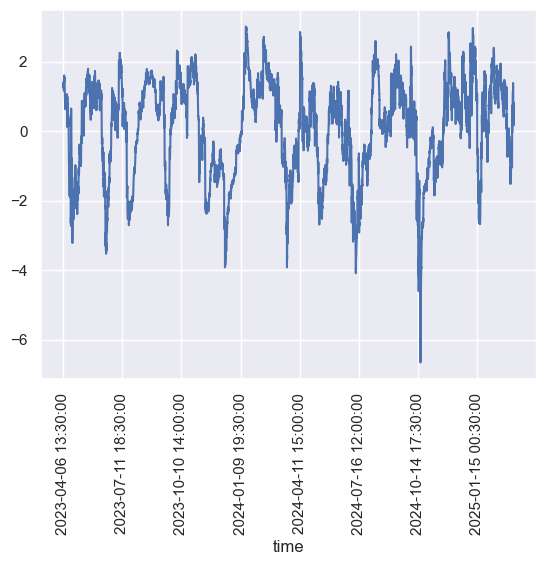

In [143]:
signals['z_score'].plot(rot=90)

In [144]:
df_test = pd.merge(left=df_test, right=signals, left_index=True, right_index=True)

df_test.head()

,close_MS,return_MS,close_IBKR,return_IBKR,spread,signal,z_score
time,,,,,,,
2023-04-06 13:30:00,84.060,0.007068,79.840,-0.002623,-108.043735,-1.0,1.367176
2023-04-06 14:00:00,84.090,0.000357,79.760,-0.001002,-108.190788,-1.0,1.338672
2023-04-06 14:30:00,83.940,-0.001784,79.795,0.000439,-107.820521,-1.0,1.404487
2023-04-06 15:00:00,84.065,0.001489,79.770,-0.000313,-108.124911,-1.0,1.344749
2023-04-06 15:30:00,84.060,-0.000059,79.680,-0.001128,-108.203735,-1.0,1.327269


In [145]:
df_test['return_spread'] = df_test['return_'+stock_2] - df_test['return_'+stock_1]
df_test['strategy_return'] = df_test['return_spread'] * df_test['signal'].shift(1)

df_test = df_test.dropna()

df_test.head()

,close_MS,return_MS,close_IBKR,return_IBKR,spread,signal,z_score,return_spread,strategy_return
time,,,,,,,,,
2023-04-06 14:00:00,84.090,0.000357,79.760,-0.001002,-108.190788,-1.0,1.338672,-0.001359,0.001359
2023-04-06 14:30:00,83.940,-0.001784,79.795,0.000439,-107.820521,-1.0,1.404487,0.002223,-0.002223
2023-04-06 15:00:00,84.065,0.001489,79.770,-0.000313,-108.124911,-1.0,1.344749,-0.001802,0.001802
2023-04-06 15:30:00,84.060,-0.000059,79.680,-0.001128,-108.203735,-1.0,1.327269,-0.001069,0.001069
2023-04-06 16:00:00,84.135,0.000892,79.710,0.000377,-108.341369,-1.0,1.298816,-0.000516,0.000516


In [149]:
df_test[stock_1 + '_cumprod'] = (1 + df_test['return_'+stock_1]).cumprod()
df_test[stock_2 + '_cumprod'] = (1 + df_test['return_'+stock_2]).cumprod()
df_test['strategy_cumprod'] = (1 + df_test['strategy_return']).cumprod()

In [150]:
import numpy as np

def compute_sharpe_ratio(returns, periods_per_year=24*365):
    return np.sqrt(periods_per_year) * returns.mean() / returns.std()

def compute_max_drawdown(cum_returns):
    return (cum_returns / cum_returns.cummax() - 1).min()

In [151]:
df = df_test

sharpe_ratio_strategy = compute_sharpe_ratio(df['strategy_return'])
sharpe_ratio_crypto_1 = compute_sharpe_ratio(df['return_'+stock_1])
sharpe_ratio_crypto_2 = compute_sharpe_ratio(df['return_'+stock_2])

max_drawdown_strategy = compute_max_drawdown(df['strategy_cumprod'])
max_drawdown_crypto_1 = compute_max_drawdown(df[stock_1+'_cumprod'])
max_drawdown_crypto_2 = compute_max_drawdown(df[stock_2+'_cumprod'])

print('-----------------------------------')
print(f"The correlation between {stock_1} and {stock_2} is {df['return_'+stock_1].corr(df['return_'+stock_2]):.4f}")
print('-----------------------------------')
print(f"Sharpe ratio for the strategy: {sharpe_ratio_strategy:.4f}")
print(f"Final return for the strategy: {df['strategy_cumprod'].iloc[-1]:.4f}")
print(f"Max drawdown for the strategy: {max_drawdown_strategy:.4f}")
print('-----------------------------------')
print(f"Sharpe ratio for {stock_1}: {sharpe_ratio_crypto_1:.4f}")
print(f"Final return for {stock_1}: {df[stock_1 +'_cumprod'].iloc[-1]:.4f}")
print(f"Max drawdown for {stock_1}: {max_drawdown_crypto_1:.4f}")
print('-----------------------------------')
print(f"Sharpe ratio for {stock_2}: {sharpe_ratio_crypto_2:.4f}")
print(f"Final return for {stock_2}: {df[stock_2 + '_cumprod'].iloc[-1]:.4f}")
print(f"Max drawdown for {stock_2}: {max_drawdown_crypto_2:.4f}")
print('-----------------------------------')

-----------------------------------
The correlation between MS and IBKR is 0.2794
-----------------------------------
Sharpe ratio for the strategy: 0.2757
Final return for the strategy: 1.0329
Max drawdown for the strategy: -0.3104
-----------------------------------
Sharpe ratio for MS: 1.1829
Final return for MS: 1.3596
Max drawdown for MS: -0.2773
-----------------------------------
Sharpe ratio for IBKR: 1.8282
Final return for IBKR: 1.8551
Max drawdown for IBKR: -0.2601
-----------------------------------


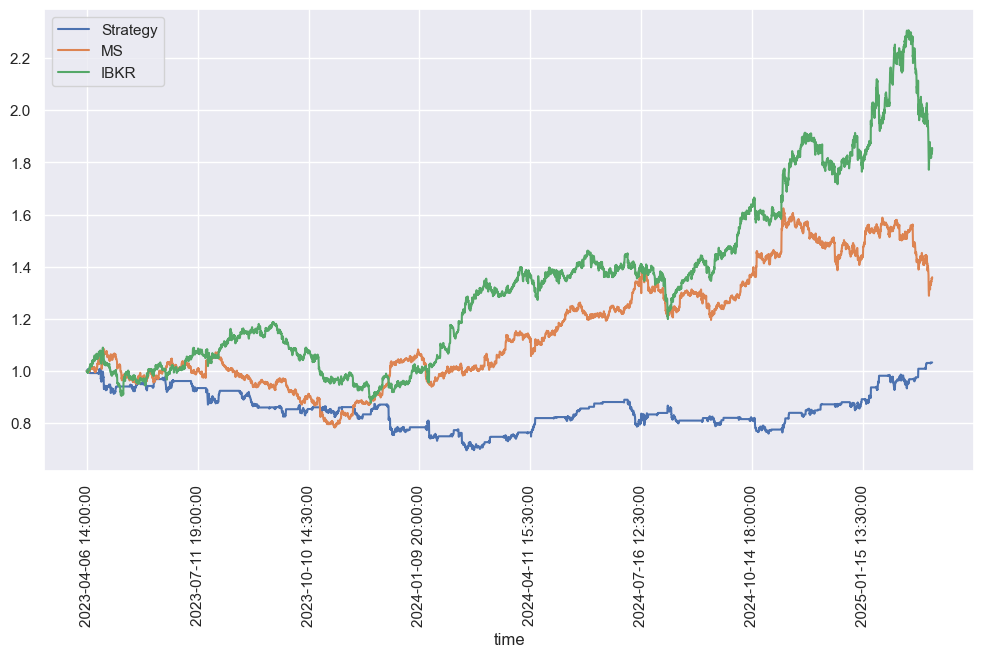

In [153]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
ax = plt.gca()  # Get the current axis

# Plot the cumulative products and strategy performance
df['strategy_cumprod'].plot(label='Strategy', rot=90, ax=ax)
df[stock_1 + '_cumprod'].plot(label=stock_1, rot=90, ax=ax)
df[stock_2 + '_cumprod'].plot(label=stock_2, rot=90, ax=ax)

plt.legend()